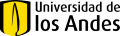

***
# **Competencia: Modelos Avanzados PLN**
# Evaluación

**Rúbrica:** Este archivo debe incluir las funciones creadas para la generación de los JSONs para los correos de prueba de la partición de test. Asegúrense de que este archivo cargue los pesos de weights.pt y lea directamente el archivo eval.json.

Este notebook genera el archivo `submission.csv` para subir a Kaggle.

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

***
# Índice

El *notebook* aborda la competencia con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️.   | **Instalación e importe de librerías** |
...
| 2️.   | **Carga de datos y construcción prompt**  |
...
| 3️. | **Inferencia** |
...
| 4️. | **Guardar resultados**   |
...

***
# 1. Instalación e importe de librerías

In [ ]:
import os
import json
import random
import gc
from typing import Any, Dict, List, Optional
import time
import math

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shared_functions as custom_sharfun

import torch
from peft import PeftModel, LoraConfig
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

## 1.1 Definición variables globales y funciones auxiliares

...

In [ ]:
def clean_memory():
    "Limpia VRAM agresivamente"
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
clean_memory()

In [ ]:
# Directorios y modelos
OUTPUT_DIR = "output/results/v10"
ADAPTER_DIR = os.path.join(OUTPUT_DIR, "modfinal_full")

# Configuración del dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

In [ ]:
pt_file = os.path.join(ADAPTER_DIR, "weights.pt")
pt_loaded = torch.load(pt_file, map_location=DEVICE)

print("Cargando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(pt_loaded["tokenizer"])
tokenizer.padding_side = "left" # A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Cargando modelo base en 4 bits...")
bnb_config = BitsAndBytesConfig(**pt_loaded["bnb_config"])

print("Modelo base:", pt_loaded["model_id"])
model_base = AutoModelForCausalLM.from_pretrained(
    pt_loaded["model_id"],
    quantization_config=bnb_config, 
    device_map="auto"
)

print("Cargando modelo LoRA...")
# Debes usar la misma configuración LoRA que usaste al entrenar
config_lora = LoraConfig(
    r = pt_loaded["config"]["lora_r"],
    lora_alpha = pt_loaded["config"]["lora_alpha"],
    lora_dropout = pt_loaded["config"]["lora_drop"],
    target_modules = pt_loaded["config"]["lora_target_mods"],
    bias=pt_loaded["config"]["lora_bias"],
    task_type=pt_loaded["config"]["lora_task_type"]
)

model = PeftModel(model_base, config_lora)
model.load_state_dict(pt_loaded["peft"], strict=False)

model.eval()

⚠️ **Advertencia**   
En las pruebas de validación se detectó que se debe aumentar MAX_LENGTH y GEN_MAX_NEW_TOKENS para que genere el JSON completo.

In [ ]:
# Data / tokenization
MAX_LENGTH = 2048
# Evaluación
GEN_MAX_NEW_TOKENS = 512
BATCH_SIZE_EVAL = 14 # ajustar según memoria GPU para ejecutar más rápido la evaluación

# Semilla de entrenamiento
GLB_SEED = pt_loaded["config"]["seed"]
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

***
# 2. Carga y construcción prompt

...
`eval.json`

In [ ]:
DATA_PATH = "data/eval/eval.json" 
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_data = json.load(f)
print(f"Número de ejemplos de evaluación: {len(raw_data)}")

In [ ]:
# Obtener longitudes - histograma
longitudes = [len(item["natural_language"]) for item in raw_data]
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

In [ ]:
# Cargar directamente un archivo JSON
val_list = load_dataset('json', data_files=DATA_PATH)['train']
print(type(val_list))  # Será datasets.Dataset

***
# 3. Inferencia

...

In [ ]:
start_time = time.time()

print(f"Generando predicciones: total datos = {len(val_list)} ...")

texts = [ex["natural_language"] for ex in val_list]
ids = [ex["id"] for ex in val_list]

pred_raw_list = custom_sharfun.generate_json_raw_batch( texts=texts, tokenizer=tokenizer, model=model, device=DEVICE, max_new_tokens=GEN_MAX_NEW_TOKENS,  max_length=MAX_LENGTH, batch_size=BATCH_SIZE_EVAL )
results_submission = []
for id_save, raw in zip(ids, pred_raw_list):
    pred_obj = custom_sharfun.extract_json_from_text(raw)
    if pred_obj is None:
        pred_obj = {}
    results_submission.append({
        "id": id_save,
        "prediction": pred_obj
    })

end_time = time.time()
print( custom_sharfun.print_time_execution("Generación de predicciones", start_time, end_time) )

In [ ]:
df_results2 = pd.DataFrame(results_submission, columns=["id", "prediction"])

# Guardar resultados

In [ ]:
CSV_DIR = os.path.join(OUTPUT_DIR, "csvfinal")
os.makedirs(CSV_DIR, exist_ok=True)

## Guardar copia en formato JSON

In [ ]:
OUTPUT_JSON2 = os.path.join(CSV_DIR, "submission_2.json")
with open(OUTPUT_JSON2, "w", encoding="utf-8") as f:
    json.dump(results_submission, f, ensure_ascii=False, indent=4)

## Guardar archivo CSV

### Funciones para transformar datos antes de guardar a CSV

In [ ]:
def fix_info(value):
    if value is None:
        return {}
    return value

def serialize_info(value):
    if value is None:
        value = {}
    return json.dumps(value, ensure_ascii=False)

In [ ]:
def normalize_example_json_pred(js: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    # Si no hay salida, devolver estructura con nulls
    if js is None or not isinstance(js, dict):
        return {
            "buyer": {"name": None, "email": None, "contact": None, "addresses": None},
            "purchases": None,
            "shipping": None,
        }

    out: Dict[str, Any] = {}

    # BUYER
    buyer = js.get("buyer") if isinstance(js.get("buyer"), dict) else (js.get("buyer") if js.get("buyer") is not None else None)
    if not buyer or not isinstance(buyer, dict):
        out["buyer"] = {"name": None, "email": None, "contact": None, "addresses": None}
    else:
        out_buyer = {
            "name": buyer.get("name") if buyer.get("name") is not None else None,
            "email": buyer.get("email") if buyer.get("email") is not None else None,
            "contact": None,
            "addresses": None,
        }
        contact = buyer.get("contact")
        if contact and isinstance(contact, dict):
            out_buyer["contact"] = {
                "phone": contact.get("phone") if contact.get("phone") is not None else None,
                "alt_email": contact.get("alt_email") if contact.get("alt_email") is not None else None,
                "preferred_contact": contact.get("preferred_contact") if contact.get("preferred_contact") is not None else None,
            }
        else:
            out_buyer["contact"] = None

        addrs = buyer.get("addresses")
        if addrs and isinstance(addrs, list) and len(addrs) > 0:
            out_addrs = []
            for a in addrs:
                if not isinstance(a, dict):
                    continue
                out_addrs.append(
                    {
                        "street": a.get("street") if a.get("street") is not None else None,
                        "city": a.get("city") if a.get("city") is not None else None,
                        "state": a.get("state") if a.get("state") is not None else None,
                        "postal_code": a.get("postal_code") if a.get("postal_code") is not None else None,
                        "country": a.get("country") if a.get("country") is not None else None,
                    }
                )
            out_buyer["addresses"] = out_addrs if out_addrs else None
        else:
            out_buyer["addresses"] = None

        out["buyer"] = out_buyer

    # PURCHASES
    purchases = js.get("purchases")
    if purchases and isinstance(purchases, list) and len(purchases) > 0:
        out_p = []
        for p in purchases:
            if not isinstance(p, dict):
                continue
            qty = p.get("quantity")
            qty_parsed = None
            try:
                if qty is not None:
                    qty_parsed = int(qty)
            except Exception:
                qty_parsed = None
            out_p.append(
                {
                    "product_name": p.get("product_name") if p.get("product_name") is not None else None,
                    "quantity": qty_parsed,
                    "currency": p.get("currency") if p.get("currency") is not None else None,
                    "discount_code": p.get("discount_code") if p.get("discount_code") is not None else None,
                }
            )
        out["purchases"] = out_p if out_p else None
    else:
        out["purchases"] = None

    # SHIPPING
    shipping = js.get("shipping")
    if shipping and isinstance(shipping, dict):
        out["shipping"] = {
            "method": shipping.get("method") if shipping.get("method") is not None else None,
            "preferred_by": shipping.get("preferred_by") if shipping.get("preferred_by") is not None else None,
        }
    else:
        out["shipping"] = None

    return out

### Transformaciones

In [ ]:
df_results_normalized = df_results2.copy()
df_results_normalized = df_results_normalized.copy()

# Normalizar al esquema esperado
df_results_normalized['normalized_prediction'] = df_results_normalized['prediction'].apply(lambda x: normalize_example_json_pred(x))

df_results_normalized_csv = df_results_normalized[["id", "normalized_prediction"]].copy()

# Convertir la columna JSON a texto
df_results_normalized_csv["prediction"] = df_results_normalized_csv["normalized_prediction"].apply(serialize_info)
df_results_normalized_csv = df_results_normalized_csv.drop(columns=["normalized_prediction"])

### Guardar CSV para subir a Kaggle

In [ ]:
# Guardar en CSV
OUTPUT_CSV = os.path.join(CSV_DIR, "submission.csv")
df_results_normalized_csv.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")